**What I want to do: **Play the statefarm distracted driver competition on kaggle by fine-tuning a pretrained deep learning model, specifically the Vgg16 model.

## Step 1 - Accept T&C for the dataset

Sign up [here](https://www.kaggle.com/c/state-farm-distracted-driver-detection). Accept the terms and conditions before you download the data.

In [1]:
%cd data

/home/ubuntu/distracted_driver/data


In [2]:
#!kg config -g -u '****' -p '*****' -c 'state-farm-distracted-driver-detection'
#!kg config

In [3]:
!kg download

downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/sample_submission.csv.zip

sample_submission.csv.zip already downloaded !
downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/imgs.zip

imgs.zip already downloaded !
downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/driver_imgs_list.csv.zip

driver_imgs_list.csv.zip already downloaded !


## Step 3 - Download the data

Enter "kg download" from the kaggle-cli after creating a separate folder called kaggle_dogscats in your data directory. Note, I'm assuming you're using a large GPU box. Otherwise this will be miserably slow.

After you've finished downloading, you'll see a sample file and 2 zip files for test and train. Unzip these latter files to get 2 new directories for test and train

unzip test.zip<br\>
unzip train.zip

In [2]:
!ls

driver_imgs_list.csv	  imgs.zip  sample_submission.csv      test   valid
driver_imgs_list.csv.zip  sample    sample_submission.csv.zip  train


## Step 4 - Explore the data

### Visually inspect the files

In [5]:
!head sample_submission.csv

img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_100001.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_100002.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_100003.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
img_100004.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


Looks like I need to give predicted probabilities. I just looked at the kaggle evals page. 2 important points: the probabilities dont need to sum to 1. The rows are rescaled. Also, the evaluation criteria is logloss, similar to dogs.

In [6]:
!head driver_imgs_list.csv

subject,classname,img
p002,c0,img_44733.jpg
p002,c0,img_72999.jpg
p002,c0,img_25094.jpg
p002,c0,img_69092.jpg
p002,c0,img_92629.jpg
p002,c0,img_3370.jpg
p002,c0,img_67639.jpg
p002,c0,img_58560.jpg
p002,c0,img_35779.jpg


subject is the driver. classes are as follows:
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

In [7]:
!ls test/ | head

img_100000.jpg
img_100001.jpg
img_100002.jpg
img_100003.jpg
img_100004.jpg
img_100005.jpg
img_100007.jpg
img_100008.jpg
img_100009.jpg
img_100010.jpg
ls: write error: Broken pipe


In [8]:
!ls train/

c0  c1	c2  c3	c4  c5	c6  c7	c8  c9


In [9]:
!ls train/c0 | head

img_100026.jpg
img_10003.jpg
img_100050.jpg
img_100074.jpg
img_10012.jpg
img_100145.jpg
img_100191.jpg
img_100257.jpg
img_100312.jpg
img_100337.jpg
ls: write error: Broken pipe


### Inspect counts for the files

In [10]:
!ls test/ | wc -l

79726


In [11]:
import os

In [12]:
dirlength={}
for dirs in os.listdir('train'):
    dirlength[dirs]=len(os.listdir(os.path.join('train',dirs)))
dirlength

{'c0': 2489,
 'c1': 2267,
 'c2': 2317,
 'c3': 2346,
 'c4': 2326,
 'c5': 2312,
 'c6': 2325,
 'c7': 2002,
 'c8': 1911,
 'c9': 2129}

In [13]:
sum(dirlength.values())

22424

Interesting to see 22K training images, and 80K testing images.

## Step 5 - Split images into training, test, validation and sample sets

Unfortunately, the script that I  used for dogscats "split_images_into_directories.py" wouldnt work exactly. This is because the competition says " The train and test data are split on the drivers, such that one driver can only appear on either train or test set. "

Therefore, one possible validation set rule is to keep all actions of 20% of the drivers. We need to use the image names file to understand this

### Step 5.1 - Explore the image file to understand the splits and such

In [3]:
import pandas as pd
df_imglist = pd.read_csv('driver_imgs_list.csv')
df_imglist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
subject      22424 non-null object
classname    22424 non-null object
img          22424 non-null object
dtypes: object(3)
memory usage: 525.6+ KB


In [4]:
df_imglist.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [5]:
print ("there are {} subjects in the training set.".format(len(df_imglist.subject.unique())))
df_imglist.subject.unique()

there are 26 subjects in the training set.


array(['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
       'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
       'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
       'p075', 'p081'], dtype=object)

So the idea should be to keep images of 5 subjects in the validation set.

In [17]:
df_imglist.groupby('subject')['img'].count()

subject
p002     725
p012     823
p014     876
p015     875
p016    1078
p021    1237
p022    1233
p024    1226
p026    1196
p035     848
p039     651
p041     605
p042     591
p045     724
p047     835
p049    1011
p050     790
p051     920
p052     740
p056     794
p061     809
p064     820
p066    1034
p072     346
p075     814
p081     823
Name: img, dtype: int64

So each subject has a couple of 100 images documenting different actions. 

In [18]:
df_imglist[df_imglist.subject=='p072'].head(10)

,subject,classname,img
20441,p072,c0,img_14047.jpg
20442,p072,c0,img_3939.jpg
20443,p072,c0,img_55929.jpg
20444,p072,c0,img_3655.jpg
20445,p072,c0,img_45462.jpg
20446,p072,c0,img_65901.jpg
20447,p072,c0,img_26089.jpg
20448,p072,c0,img_80621.jpg
20449,p072,c0,img_71951.jpg
20450,p072,c0,img_47528.jpg


In [19]:
df_imglist[df_imglist.subject=='p072'].sort_values(by=['classname','img']).head(10)

,subject,classname,img
20466,p072,c0,img_100598.jpg
20457,p072,c0,img_104.jpg
20485,p072,c0,img_1053.jpg
20490,p072,c0,img_1215.jpg
20487,p072,c0,img_12458.jpg
20469,p072,c0,img_13121.jpg
20441,p072,c0,img_14047.jpg
20470,p072,c0,img_1519.jpg
20451,p072,c0,img_15823.jpg
20456,p072,c0,img_24750.jpg


Images dont seem to be sorted in any discernable order. Lets roll with it....

In [20]:
# another check is to see wehether the image numbers overlap with different subjects?
assert df_imglist.shape[0] == len(df_imglist.img.unique()), "image ids repeat for different subjects!"

### Step 5.2 - Copy 20% of training data into validation set

20% roughly equals 5 subjects. So lets remove 5 subjects at random and place it into the validation set.

In [7]:
import numpy as np
from numpy import random
from numpy.random import RandomState
ddrandom = RandomState(42)

In [8]:
random.seed(42)
validation_subjects = ddrandom.choice(df_imglist.subject.unique(),size=5)

In [10]:
import os,sys,shutil

In [79]:
# first create validation directory if does not exist
if not os.path.isdir('valid'):
    !mkdir valid

for distraction_classes in os.listdir('train'):
    # create class sub-directory if does not exist
    if not os.path.isdir(os.path.join('valid',distraction_classes)):
        temp_filename = os.path.join('valid',distraction_classes)
        !mkdir $temp_filename
    
    # perform a check for each image in training class
    img_move_counter = 0
    for images in os.listdir(os.path.join('train',distraction_classes)):
        if (images==df_imglist[df_imglist.subject.isin(validation_subjects)]['img']).any():
            shutil.move(os.path.join('train',distraction_classes,images), 
                        os.path.join('valid',distraction_classes,images))
            img_move_counter+=1
    
    # print completion status after each class
    print ('Moved {} images in class {}:'.format(str(img_move_counter),distraction_classes))

Moved 419 images in class c7:
Moved 432 images in class c8:
Moved 484 images in class c6:
Moved 485 images in class c0:
Moved 487 images in class c2:
Moved 485 images in class c4:
Moved 474 images in class c9:
Moved 492 images in class c1:
Moved 488 images in class c3:
Moved 493 images in class c5:


### Step 5.3 - Copy 1% of training and validation data into sample training and validation set

From every class within train and valid, pick a 1% random sample and add a 'sample' at the front.

In [12]:
# predefine directories and distraction_classes for testing
#directories='train'; distraction_classes = 'c0'
blah = os.listdir(os.path.join(directories,distraction_classes))
ddrandom.choice(blah,2)

array(['img_10446.jpg', 'img_4447.jpg'],
      dtype='|S14')

In [15]:
# first create sample directory if does not exist
if not os.path.isdir('sample'):
    !mkdir sample
    
for directories in ['train','valid']:
    for distraction_classes in os.listdir(directories):
        
        # initialise number of samples and filenames for copying
        number_of_samples = int(0.01*len(os.listdir(os.path.join(directories,distraction_classes))))
        all_filenames = os.listdir(os.path.join(directories,distraction_classes))
        img_cp_counter=0
        
        # run loop for copying
        for images in ddrandom.choice(all_filenames,number_of_samples):
            
            # create sample directory and sub-directory to put image into if does not exist
            if not os.path.isdir(os.path.join('sample',directories)):
                temp_filename = os.path.join('sample',directories)
                !mkdir $temp_filename            
            if not os.path.isdir(os.path.join('sample',directories,distraction_classes)):
                temp_filename = os.path.join('sample',directories,distraction_classes)
                !mkdir $temp_filename
            
            shutil.copy2(os.path.join(directories,distraction_classes,images),
                        os.path.join('sample',directories,distraction_classes,images))
            
            img_cp_counter+=1
        
        # print completion status after each class
        print ('Copied {} images to sample in class {}:'.format(str(img_cp_counter),directories+'/'+distraction_classes))

Copied 15 images to sample in class train/c7:
Copied 14 images to sample in class train/c8:
Copied 18 images to sample in class train/c6:
Copied 20 images to sample in class train/c0:
Copied 18 images to sample in class train/c2:
Copied 18 images to sample in class train/c4:
Copied 16 images to sample in class train/c9:
Copied 17 images to sample in class train/c1:
Copied 18 images to sample in class train/c3:
Copied 18 images to sample in class train/c5:
Copied 4 images to sample in class valid/c7:
Copied 4 images to sample in class valid/c8:
Copied 4 images to sample in class valid/c6:
Copied 4 images to sample in class valid/c0:
Copied 4 images to sample in class valid/c2:
Copied 4 images to sample in class valid/c4:
Copied 4 images to sample in class valid/c9:
Copied 4 images to sample in class valid/c1:
Copied 4 images to sample in class valid/c3:
Copied 4 images to sample in class valid/c5:


## Step 7: Get some intuition of the images

Valid folder is now sacred. Cant touch it. Let me actually take a look at the training images to get a sense of what the dudes are doing.

In [17]:
os.listdir('train/c0')[:4]

['img_95728.jpg', 'img_73423.jpg', 'img_74437.jpg', 'img_58721.jpg']

In [28]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


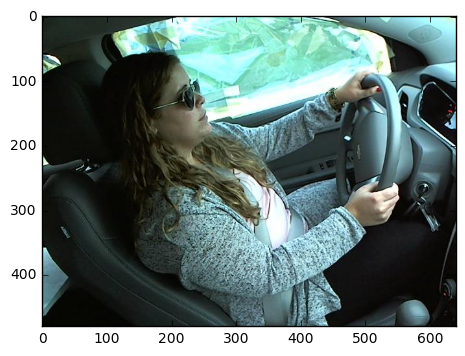

In [29]:
img=mpimg.imread('train/c0/img_95728.jpg')
imgplot = plt.imshow(img)
plt.show()

In [40]:
def show_driver_training_images(subdirectory):
    fig = plt.figure(figsize=(12,8))
    # subplot counter actually stands for 1 row 4 columns and 1st position
    subplot_counter=141 

    for images in os.listdir(subdirectory)[:4]:
        ax = fig.add_subplot(subplot_counter)
        img=mpimg.imread(os.path.join(subdirectory,images))
        imgplot = plt.imshow(img)
        subplot_counter+=1
    plt.show()

In [56]:
#show_driver_training_images('train/c0')

The one above is about people driving safely.

In [57]:
#show_driver_training_images('train/c1')

The one above is about people texting with right hand

In [58]:
#show_driver_training_images('train/c2')

The one above is about people talking on phone with right hand

In [59]:
#show_driver_training_images('train/c3')

The one above is about people texting with left hand

In [60]:
#show_driver_training_images('train/c4')

The one above is about people talking on phone with left hand

In [61]:
#show_driver_training_images('train/c5')

The one above is about people operating the radio

In [62]:
#show_driver_training_images('train/c6')

The one above is about people holding coffee cup in right hand

In [63]:
#show_driver_training_images('train/c7')

The one above is about people fixating on something near the passenger seat

In [64]:
#show_driver_training_images('train/c8')

The one above is about people driving with one hand. The actual class according to competition documentation is "hair and makeup". Boy, this one is hard.

In [65]:
#show_driver_training_images('train/c9')

The one above is about people talking to their co-passenger beside them

Alright alright alright. Lets get to it...